## Assessing the antibody validation status 

**Input:**  Antibody validation status obtained from <a href="https://www.nature.com/articles/nmeth.2650#Sec1">TCPA Supplemental Table 1</a> and <a href=https://www.mdanderson.org/>MD Anderson Cancer Center</a>

**Output:** Table S1, S2 and Figure S1

### Import Packages

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

import graphing_utils
import customized_plot 
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_table_path = lambda fname: os.path.normpath('../tables/' + fname)
get_figure_path = lambda fname: os.path.normpath('../figures/' + fname)

file_antibody_standard = get_data_path(['mdanderson_cancer_center'], 'RPPA_Standard_Ab_List_Updated.xlsx')
file_antibody_genes_corrected = get_data_path(['mdanderson_cancer_center'], 'Corrected_Gene_Names.xlsx')
file_antibody_tcpa = get_data_path(['jun_li_2013'], 'nmeth.2650-S2.xlsx')

file_sourceData_FigureS1 = get_table_path('SourceDataForFigureS1.csv')
file_table_s1 = get_table_path('TableS1.xlsx')
file_table_s2 = get_table_path('TableS2.xlsx')

### Load data

<div class="alert alert-block alert-warning">
    We include antibodies in our analyses only when it:          
    <li> targets no more than one protein</li>
    <li> does not target phosphoproteins </li>
    <li> is marked as 'Valid' or 'Caution'</li>   
</div>

In [3]:
antibody_tcpa_status = pd.read_excel(file_antibody_tcpa, skiprows=1, engine = 'openpyxl',
                                     usecols=['Protein Name', 'Gene Name', 'Antibody validation status', 
                                              'Antibody Origin', 'Antibody Source (Company)', 'Catalog Number'])\
                         .rename(columns={'Gene Name': 'GeneName', 'Antibody validation status': 'ValidationStatus', 
                                          'Protein Name': 'ProteinName'})
print("Dimensions:", antibody_tcpa_status.shape)
antibody_tcpa_status[:2]

Dimensions: (187, 6)


,ProteinName,GeneName,ValidationStatus,Antibody Origin,Antibody Source (Company),Catalog Number
0,14-3-3_epsilon,YWHAE,Use with Caution,Mouse,Santa Cruz,sc-23957
1,4E-BP1_pS65,EIF4EBP1,Validated,Rabbit,CST,9456


In [4]:
antibody_tcpa_status['ValidationStatus'].value_counts()

Validated           115
Use with Caution     43
Under Evaluation     29
Name: ValidationStatus, dtype: int64

- Remove Phospho-proteins

In [5]:
antibody_tcpa_status_subset = antibody_tcpa_status[~antibody_tcpa_status['ProteinName'].str.contains('_p', regex=True)]
antibody_tcpa_status_subset.dropna(subset=['GeneName'], inplace=True)
antibody_tcpa_status_subset.shape

(135, 6)

- Remove antibodies that map to more than one gene/protein

In [6]:
antibody_tcpa_status_subset[antibody_tcpa_status_subset['GeneName'].str.contains(' ')]

,ProteinName,GeneName,ValidationStatus,Antibody Origin,Antibody Source (Company),Catalog Number
9,Akt,AKT1 AKT2 AKT3,Validated,Rabbit,CST,9272
37,cIAP,BIRC2,Use with Caution,Rabbit,Millipore,07-759
59,GSK3-alpha-beta,GSK3A GSK3B,Validated,Mouse,Santa Cruz,SC-7291
98,PI3K-p110-alpha,PIK3CA,Use with Caution,Rabbit,CST,4255
100,PKC-alpha,PRKCA,Validated,Mouse,Upstate (Millipore),05-154
162,Rab11,RAB11A RAB11B,Under Evaluation,Rabbit,CST,3539
180,Rab25,Rab 25,Validated,Rabbit,CST,4314


In [7]:
antibody_tcpa_status_subset['GeneName'] = antibody_tcpa_status_subset['GeneName'].apply(lambda x: x.strip())
antibody_tcpa_status_subset.replace('Rab 25', 'Rab25', inplace=True)
antibody_tcpa_status_subset = antibody_tcpa_status_subset[~antibody_tcpa_status_subset['GeneName'].str.contains(' ')]
antibody_tcpa_status_subset.shape

(132, 6)

In [8]:
#selecting only two columns to work with
antibody_tcpa_status_subset = antibody_tcpa_status_subset[['ProteinName', 'GeneName', 'ValidationStatus', 
                                             'Antibody Source (Company)','Catalog Number']].set_index('ProteinName')
antibody_tcpa_status_subset['GeneName'] = antibody_tcpa_status_subset['GeneName'].str.strip()
antibody_tcpa_status_subset['AntibodyValidationSource'] = 'TCPA Supplemental Table'
antibody_tcpa_status_subset[:2]

,GeneName,ValidationStatus,Antibody Source (Company),Catalog Number,AntibodyValidationSource
ProteinName,,,,,
14-3-3_epsilon,YWHAE,Use with Caution,Santa Cruz,sc-23957,TCPA Supplemental Table
4E-BP1,EIF4EBP1,Validated,CST,9452,TCPA Supplemental Table


In [9]:
antibody_tcpa_status_subset.isnull().sum()

GeneName                     0
ValidationStatus             0
Antibody Source (Company)    0
Catalog Number               0
AntibodyValidationSource     0
dtype: int64

In [10]:
antibody_tcpa_status_subset['ValidationStatus'].value_counts()

Validated           78
Use with Caution    30
Under Evaluation    24
Name: ValidationStatus, dtype: int64

In [11]:
antibody_tcpa_indexed = antibody_tcpa_status_subset.reset_index().set_index(['ProteinName', 'GeneName', 
                                                                      'Antibody Source (Company)', 'Catalog Number'])
antibody_tcpa_indexed = antibody_tcpa_indexed[antibody_tcpa_indexed['ValidationStatus']=='Under Evaluation']
antibody_tcpa_indexed[:2]

,,,,ValidationStatus,AntibodyValidationSource
ProteinName,GeneName,Antibody Source (Company),Catalog Number,,
53BP1,TP53BP1,CST,4937,Under Evaluation,TCPA Supplemental Table
ACC1,ACACA,Epitomics,1768-1,Under Evaluation,TCPA Supplemental Table


In [12]:
all_standard_antibodies = pd.read_excel(file_antibody_standard, skiprows=5, 
                                        sheet_name=['Current_Standard Ab List_304', 'Previous_Standard Ab List_281', 
                                                    'Previous_Standard Ab List_283', 'Previous_Standard Ab List_284', 
                                                    'Previous_Standard Ab List_286', 'Previous_Standard Ab List_298', 
                                                    'Previous_Standard Ab List_302', 'Previous_Standard Ab List_304', 
                                                    'Previous_Standard Ab List_305', 'Previous_Standard Ab List_304_', 
                                                    'Previous_Standard Ab List_304.', 'Previous_Standard Ab List_304-', 
                                                    'Previous_Standard Ab List_302.', 'Previous_Standard Ab List_302_', 
                                                    'Previous_Standard Ab List_303', 'Previous_Standard Ab List_304a', 
                                                    'Previous_Standard Ab List_304b', 'Previous_Standard Ab List_304c'],
                                        usecols=['Ab Name Reported on Dataset', 'Gene Name', 'Validation Status*', 'Company', 
                                                 'Catalog #' , 'Species'])
all_standard_antibodies = pd.concat(all_standard_antibodies.values(), ignore_index=True).dropna()
all_standard_antibodies['Validation Status*'] = all_standard_antibodies['Validation Status*'].replace('Caution', 
                                                                                                      'Use with Caution')
# Removing phophorylated proteins or their genes
all_standard_antibodies = all_standard_antibodies[~all_standard_antibodies['Ab Name Reported on Dataset'].str.contains('_p', 
                                                                                                          regex=True)]
all_standard_antibodies['Gene Name'] = all_standard_antibodies['Gene Name'].str.strip()
all_standard_antibodies = all_standard_antibodies[~all_standard_antibodies['Gene Name'].str.contains(',|-')]
all_standard_antibodies = all_standard_antibodies.drop_duplicates()
all_standard_antibodies.drop_duplicates(subset = ['Ab Name Reported on Dataset','Gene Name','Company','Catalog #'], inplace=True)
all_standard_antibodies = all_standard_antibodies[~all_standard_antibodies['Validation Status*'].str.contains('Under Evaluation')]
 
print("Dimensions: " , all_standard_antibodies.shape)
all_standard_antibodies[:2]

Dimensions:  (305, 6)


,Ab Name Reported on Dataset,Gene Name,Company,Catalog #,Species,Validation Status*
0,14-3-3-beta,YWHAB,Santa Cruz,sc-628,Rabbit,Valid
1,14-3-3-zeta,YWHAZ,Santa Cruz,sc-1019,Rabbit,Valid


In [13]:
all_standard_antibodies.rename(columns={'Ab Name Reported on Dataset':'ProteinName', 'Gene Name': 'GeneName', 
                                        'Company': 'Antibody Source (Company)', 'Catalog #' : 'Catalog Number'}, inplace=True)
all_standard_antibodies.set_index(['ProteinName', 'GeneName', 'Antibody Source (Company)', 'Catalog Number'], inplace=True)
all_standard_antibodies[:2]

,,,,Species,Validation Status*
ProteinName,GeneName,Antibody Source (Company),Catalog Number,,
14-3-3-beta,YWHAB,Santa Cruz,sc-628,Rabbit,Valid
14-3-3-zeta,YWHAZ,Santa Cruz,sc-1019,Rabbit,Valid


In [14]:
#Antibody validation status obtained for antibodies with status marked as 'Under evaluation'
under_evaluation_with_status = pd.concat([antibody_tcpa_indexed, all_standard_antibodies], join='inner', axis=1)
under_evaluation_with_status

,,,,ValidationStatus,AntibodyValidationSource,Species,Validation Status*
ProteinName,GeneName,Antibody Source (Company),Catalog Number,,,,
53BP1,TP53BP1,CST,4937,Under Evaluation,TCPA Supplemental Table,Rabbit,Valid
Chk2,CHEK2,CST,3440,Under Evaluation,TCPA Supplemental Table,Mouse,Valid
P-Cadherin,CDH3,CST,2130,Under Evaluation,TCPA Supplemental Table,Rabbit,Use with Caution
p53,TP53,CST,9282,Under Evaluation,TCPA Supplemental Table,Rabbit,Use with Caution
PAI-1,SERPINE1,BD Biosciences,612024,Under Evaluation,TCPA Supplemental Table,Mouse,Valid
XRCC1,XRCC1,CST,2735,Under Evaluation,TCPA Supplemental Table,Rabbit,Use with Caution
YAP,YAP1,Santa Cruz,sc-15407,Under Evaluation,TCPA Supplemental Table,Rabbit,Use with Caution


In [15]:
under_evaluation_with_status = under_evaluation_with_status.reset_index().set_index('ProteinName').drop(columns=['Species', 
                               'ValidationStatus']).rename(columns={'Validation Status*': 'ValidationStatus'})
under_evaluation_with_status['AntibodyValidationSource'] = 'MD Anderson Standard List of Antibodies'
under_evaluation_with_status[:2]

,GeneName,Antibody Source (Company),Catalog Number,AntibodyValidationSource,ValidationStatus
ProteinName,,,,,
53BP1,TP53BP1,CST,4937,MD Anderson Standard List of Antibodies,Valid
Chk2,CHEK2,CST,3440,MD Anderson Standard List of Antibodies,Valid


In [16]:
antibody_tcpa_status_subset = antibody_tcpa_status_subset[antibody_tcpa_status_subset['ValidationStatus'] != 'Under Evaluation']
antibody_tcpa_status_subset = pd.concat([antibody_tcpa_status_subset, under_evaluation_with_status]).reset_index()
antibody_tcpa_status_subset['ProteinName'] = antibody_tcpa_status_subset['ProteinName'].replace('-|_','', 
                                                                                  regex=True).apply(lambda x: x.upper())
antibody_tcpa_status_subset[:2]

,ProteinName,GeneName,ValidationStatus,Antibody Source (Company),Catalog Number,AntibodyValidationSource
0,1433EPSILON,YWHAE,Use with Caution,Santa Cruz,sc-23957,TCPA Supplemental Table
1,4EBP1,EIF4EBP1,Validated,CST,9452,TCPA Supplemental Table


In [17]:
antibody_genes_corrected = pd.read_excel(file_antibody_genes_corrected)
antibody_genes_corrected.columns=['Version', 'Official Ab Name ', 'Ab Name Reported on Dataset',
                                  'Gene Name', 'Company', 'Catalog #', 'Internal Ab ID', 'Species',
                                  'Validation  Status', 'RPPA Dilution', 'Storage']
antibody_genes_corrected[:2]

,Version,Official Ab Name,Ab Name Reported on Dataset,Gene Name,Company,Catalog #,Internal Ab ID,Species,Validation Status,RPPA Dilution,Storage
0,Corrected,Acetyl-CoA-Carboxylase,ACC1,"ACACA, B",Epitomics,1768-1,14,Rabbit,Caution,1:1500,-20
1,Previous,Acetyl-CoA-Carboxylase,ACC1,ACACA,Epitomics,1768-1,14,Rabbit,Caution,1:1500,-20


In [18]:
antibody_genes_corrected = antibody_genes_corrected[antibody_genes_corrected['Version'] == 'Corrected']
antibody_genes_corrected = antibody_genes_corrected[['Ab Name Reported on Dataset', 'Gene Name', 'Company', 'Catalog #']]
antibody_genes_corrected = antibody_genes_corrected[~antibody_genes_corrected['Ab Name Reported on Dataset'].str.contains('_p')]
# antibody_genes_corrected['Ab Name Reported on Dataset'] = antibody_genes_corrected['Ab Name Reported on Dataset'].replace('-|_','', 
#                                                                                   regex=True).apply(lambda x: x.upper())
antibody_genes_corrected

,Ab Name Reported on Dataset,Gene Name,Company,Catalog #
0,ACC1,"ACACA, B",Epitomics,1768-1
2,ACC1,"ACACA, B",Abcam,ab45174
6,AMPKa,"PRKAA1, 2",CST,2532
10,Aurora-B,AURKB,CST,3094
12,c-Abl,ABL1,CST,2862
14,CD26,DPP4,Abcam,ab28340
18,Connexin-43,GJA1,CST,3512
20,Cox-IV,COX4I1,CST,4850
22,D-a-Tubulin,"TUBA4A,\nTUBA3C",Abcam,ab48389
24,DM-Histone-H3,HIST1H3A,CST,9725


In [19]:
corrected_ab_data = pd.concat([antibody_tcpa_status_subset.set_index(['ProteinName', 'Antibody Source (Company)', 'Catalog Number']), 
                            antibody_genes_corrected.set_index(['Ab Name Reported on Dataset', 'Company',
                                                                'Catalog #'])['Gene Name']], 
                           axis=1).reset_index().dropna(subset=['ValidationStatus']).rename(columns={'level_0': 'ProteinName', 
                                                                                                     'level_1': 'Company', 
                                                                                                     'level_2': 'Catalog #'})
corrected_ab_data[:2]

,ProteinName,Company,Catalog #,GeneName,ValidationStatus,AntibodyValidationSource,Gene Name
0,1433EPSILON,Santa Cruz,sc-23957,YWHAE,Use with Caution,TCPA Supplemental Table,NaN
1,4EBP1,CST,9452,EIF4EBP1,Validated,TCPA Supplemental Table,NaN


In [20]:
corrected_ab_data['GeneName'] = corrected_ab_data["GeneName"].fillna(corrected_ab_data["Gene Name"])
corrected_ab_data = corrected_ab_data.drop(columns=['Gene Name']).set_index('ProteinName')
corrected_ab_data = corrected_ab_data[~corrected_ab_data['GeneName'].str.contains('/')].reset_index()
print("Dimensions: ", corrected_ab_data.shape)
corrected_ab_data[:2]

Dimensions:  (114, 6)


,ProteinName,Company,Catalog #,GeneName,ValidationStatus,AntibodyValidationSource
0,1433EPSILON,Santa Cruz,sc-23957,YWHAE,Use with Caution,TCPA Supplemental Table
1,4EBP1,CST,9452,EIF4EBP1,Validated,TCPA Supplemental Table


In [21]:
corrected_ab_data.replace('Validated', 'Valid', inplace=True)
corrected_ab_data.to_excel(file_table_s1, index=False, sheet_name='AntibodiesUsedForAnalyses')
corrected_ab_data.loc[corrected_ab_data[corrected_ab_data.index.duplicated()].index]

,ProteinName,Company,Catalog #,GeneName,ValidationStatus,AntibodyValidationSource


### Antibodies that are not used for our analyses

In [22]:
# antibody_tcpa_status['GeneName'] = antibody_tcpa_status['GeneName'].apply(lambda x: x.strip())
antibody_tcpa_status.replace('Rab 25', 'Rab25', inplace=True)
antibodies_not_used = antibody_tcpa_status[~antibody_tcpa_status['Catalog Number'].isin(corrected_ab_data['Catalog #'].to_list())]
antibodies_not_used.drop(columns=['Antibody Origin'], inplace=True)
print("Dimensions: ", antibodies_not_used.shape)
antibodies_not_used[:2]

Dimensions:  (73, 5)


,ProteinName,GeneName,ValidationStatus,Antibody Source (Company),Catalog Number
1,4E-BP1_pS65,EIF4EBP1,Validated,CST,9456
2,4E-BP1_pT37,EIF4EBP1,Validated,CST,9459


In [23]:
antibodies_not_used = pd.concat([antibodies_not_used.set_index(['ProteinName', 'Antibody Source (Company)', 'Catalog Number']), 
                                 antibody_genes_corrected.set_index(['Ab Name Reported on Dataset', 'Company',
                                                                'Catalog #'])['Gene Name']], 
                           axis=1).reset_index().dropna(subset=['ValidationStatus']).rename(columns={'level_0': 'ProteinName', 
                                                                                                     'level_1': 'Company', 
                                                                                                     'level_2': 'Catalog #'})
antibodies_not_used['Gene Name'] = antibodies_not_used["Gene Name"].fillna(antibodies_not_used["GeneName"])
antibodies_not_used = antibodies_not_used.drop(columns=['GeneName']).rename(columns={'Gene Name': 'GeneName'})
print("Dimensions: ", antibodies_not_used.shape)

antibodies_not_used[:2]

Dimensions:  (73, 5)


,ProteinName,Company,Catalog #,ValidationStatus,GeneName
0,4E-BP1_pS65,CST,9456,Validated,EIF4EBP1
1,4E-BP1_pT37,CST,9459,Validated,EIF4EBP1


In [24]:
antibodies_not_used['ReasonToExclude'] = 'Unknown Validation Status'
phosphorylated_protein = 'Phosphorylated Protein(s)'
targets_multiple_proteins = 'Targets multiple proteins'

antibodies_not_used['ReasonToExclude'] = np.where(antibodies_not_used['ProteinName'].str.contains('_p'), 
                                                 phosphorylated_protein, 
                                                 np.where(antibodies_not_used['GeneName'].str.contains(' |_|/'), 
                                                          targets_multiple_proteins, antibodies_not_used['ReasonToExclude']))
antibodies_not_used.loc[antibodies_not_used['GeneName'].isnull(), 'ReasonToExclude'] = "Unknown target protein"
antibodies_not_used.to_excel(file_table_s2, index=False, sheet_name='AntibodiesExcludedFromAnalyses')

#### Assessing the antibodies that are being used

In [25]:
#selecting only two columns to work with
antibody_status_subset = corrected_ab_data[['ProteinName', 'GeneName', 'ValidationStatus']]

In [26]:
antibody_status_subset['ValidationStatus'].value_counts()

Valid               80
Use with Caution    34
Name: ValidationStatus, dtype: int64

In [27]:
antibody_status_subset['ValidationStatus'].value_counts(normalize=True)

Valid               0.701754
Use with Caution    0.298246
Name: ValidationStatus, dtype: float64

In [28]:
antibody_status_subset.to_csv(file_sourceData_FigureS1, index=False)
antibody_status_subset[:2]

,ProteinName,GeneName,ValidationStatus
0,1433EPSILON,YWHAE,Use with Caution
1,4EBP1,EIF4EBP1,Valid


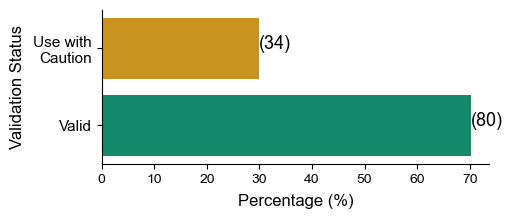

In [29]:
palette = [graphing_utils.get_color(color) for color in ['orange', 'green']]
args = graphing_utils.additional_plot_parameters(xlab="Percentage (%)", ylab="Validation Status", fontsize='x-large',
                                                             palette = palette)
percentage = lambda i: len(i) / float(len(x)) * 100
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':12, 'axes.spines.left': True, 'xtick.labelsize':10, 
                     'ytick.labelsize':11}):
    figure, ax = plt.subplots(1, 1, figsize=(5, 2))
    customized_plot.draw_countplot(antibody_status_subset, ax, args)
#     figure.savefig(get_figure_path('FigureS1.svg'), bbox_inches='tight', dpi=300)

<div class="alert alert-block alert-success">
    ~30% of the antibodies used for analyses are marked as 'Caution'.
</div>